In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
import util
import tensorflow as tf
import numpy as np
from sklearn.metrics import *

## Importing the data (students or titanic)

### Students:

In [2]:
import students
dataset, both_sides = students.get_all()
left_train, left_test, right_train, right_test, y_train, y_test = util.train_test(both_sides, 36, 72)

['math score', 'gender_female', 'gender_male', 'race/ethnicity_group A', 'race/ethnicity_group B', 'race/ethnicity_group C', 'race/ethnicity_group D', 'race/ethnicity_group E', "parental_associate's degree", "parental_bachelor's degree", 'parental_high school', "parental_master's degree", 'parental_some college', 'parental_some high school', 'lunch_free/reduced', 'lunch_standard', 'preparation_completed', 'preparation_none']
18


### Titanic:

In [3]:
import titanic
dataset, both_sides = titanic.get_all()
left_train, left_test, right_train, right_test, y_train, y_test = util.train_test(both_sides, 18, 36)

['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S']
['pclass_x', 'age_x', 'sibsp_x', 'parch_x', 'fare_x', 'sex_female_x', 'sex_male_x', 'embarked_C_x', 'embarked_Q_x', 'embarked_S_x', 'pclass_y', 'age_y', 'sibsp_y', 'parch_y', 'fare_y', 'sex_female_y', 'sex_male_y', 'embarked_C_y', 'embarked_Q_y', 'embarked_S_y', 'embarked_S_x', 'pclass_y', 'age_y', 'sibsp_y', 'parch_y', 'fare_y', 'sex_female_y', 'sex_male_y', 'embarked_C_y', 'embarked_Q_y', 'embarked_S_y', 'pclass_x', 'age_x', 'sibsp_x', 'parch_x', 'fare_x', 'sex_female_x', 'sex_male_x', 'embarked_C_x', 'embarked_Q_x', 'first_better']


### Credit Card

In [2]:
import credit_card
dataset, both_sides = credit_card.get_all()
left_train, left_test, right_train, right_test, y_train, y_test = util.train_test(both_sides, 46, 92)

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']
24
['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
23


In [5]:
both_sides.head()

,pclass_x,age_x,sibsp_x,parch_x,fare_x,sex_female_x,sex_male_x,embarked_C_x,embarked_Q_x,embarked_S_x,...,pclass_x,age_x,sibsp_x,parch_x,fare_x,sex_female_x,sex_male_x,embarked_C_x,embarked_Q_x,first_better
0,1,0.361142,0.0,0.0,0.412503,1.0,0,0,0,1,...,1.0,0.361142,0.0,0.0,0.412503,1,0,0,0,1
1,1,0.361142,0.0,0.0,0.412503,1.0,0,0,0,1,...,1.0,0.361142,0.0,0.0,0.412503,1,0,0,0,1
2,1,0.361142,0.0,0.0,0.412503,1.0,0,0,0,1,...,1.0,0.361142,0.0,0.0,0.412503,1,0,0,0,1
3,1,0.361142,0.0,0.0,0.412503,1.0,0,0,0,1,...,1.0,0.361142,0.0,0.0,0.412503,1,0,0,0,1
4,1,0.361142,0.0,0.0,0.412503,1.0,0,0,0,1,...,1.0,0.361142,0.0,0.0,0.412503,1,0,0,0,1


### Shapes of the chosen dataset and its subsets:

In [3]:
print(dataset.shape, both_sides.shape)
print(left_train.shape, left_test.shape, right_train.shape, right_test.shape, y_train.shape, y_test.shape)

(5000, 24) (8619102, 93)
(6895281, 46) (1723821, 46) (6895281, 46) (1723821, 46) (6895281, 1) (1723821, 1)


## Neural Network

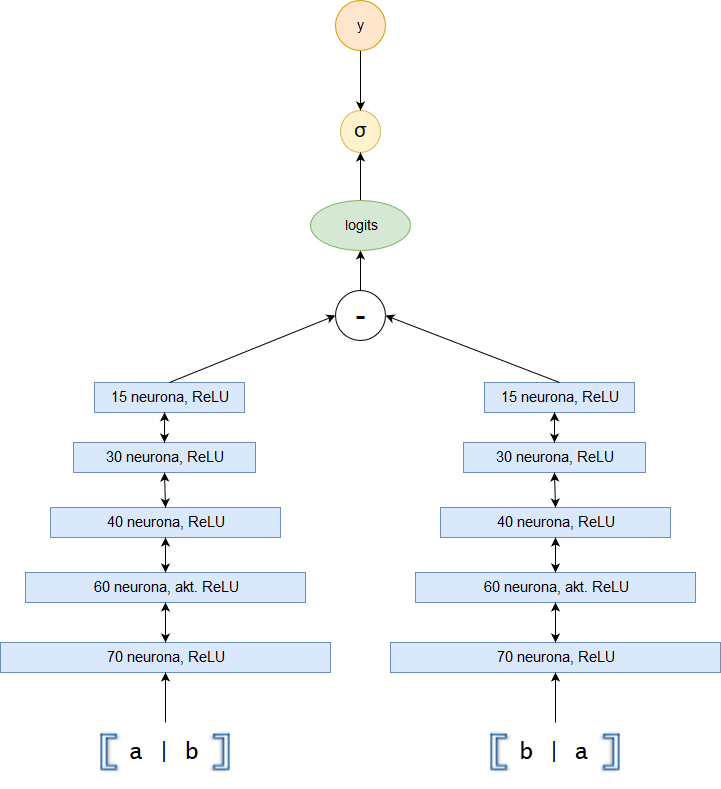

In [13]:
Image(filename="nn.png") 

In [6]:
def small_network(input_placeholder):
    layer_1 = tf.layers.dense(input_placeholder, 70, tf.nn.relu, name="layer_1", reuse=tf.AUTO_REUSE)
    layer_2 = tf.layers.dense(layer_1, 60, tf.nn.relu, name="layer_2", reuse=tf.AUTO_REUSE)
    layer_3 = tf.layers.dense(layer_2, 40, tf.nn.relu, name="layer_3", reuse=tf.AUTO_REUSE)
    layer_4 = tf.layers.dense(layer_3, 30, tf.nn.relu, name="layer_4", reuse=tf.AUTO_REUSE)
    layer_5 = tf.layers.dense(layer_4, 15, tf.nn.relu, name="layer_5", reuse=tf.AUTO_REUSE)
    output = tf.layers.dense(layer_5, 1, name="output", reuse=tf.AUTO_REUSE)
    return output

In [7]:
def metrics(y_out, y_test):
    y_out[y_out >= 0.5] = 1
    y_out[y_out < 0.5] = 0
    
    print('\nAccuracy score = ', accuracy_score(y_test, y_out))
    print('Accuracy score = ', precision_score(y_test, y_out))
    print('Accuracy score = ', accuracy_score(y_test, y_out))
    print('Area under curve = \t', roc_auc_score(y_true= y_test, y_score=y_out))
    print('F1 score = ', f1_score(y_test, y_out))

In [8]:
tf.reset_default_graph()

input_left = tf.placeholder(tf.float32, shape=[None, left_train.shape[1]])
input_right = tf.placeholder(tf.float32, shape=[None, right_train.shape[1]])
output = tf.placeholder(tf.float32, shape=[None, 1])

f_left = small_network(input_left)
f_right = small_network(input_right)
logit = f_left - f_right
h = tf.sigmoid(logit)

loss = tf.losses.sigmoid_cross_entropy(output, logit)

### Train & test

In [9]:
def train_test(left_input, right_input, y, num_epochs, batch_size):
    outputs = np.zeros([y.shape[0], 1])
    h_ = np.zeros([y.shape[0], 1])
    
    lr = tf.placeholder(tf.float32)
    train_op = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    num_batches = left_train.shape[0] // batch_size
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in range(num_batches):
            i = batch * batch_size
            j = (batch + 1) * batch_size
            
            loss_, outputs[i:j], h_[i:j], _ = sess.run([loss, logit,h, train_op], feed_dict={input_left: left_input[i:j], 
                                                             input_right: right_input[i:j],
                                                             output: y[i:j], lr: 0.1})
            
            total_loss += loss_
        print("Epoch {} / {}, Loss = {}".format(epoch + 1, num_epochs, total_loss / batch_size))
        
    return outputs, h_, left_input

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    y_out, h_out, left_in = train_test(left_train, right_train, y_train, 10, 1000) #1551
    metrics(y_out, y_train)
    
    print("\nTesting...")
    y_out, h_out, left_in = train_test(left_test, right_test, y_test, 1, 1000) #1433 #2347
    metrics(y_out, y_test)

Training...
Epoch 1 / 10, Loss = 3.284154748171568
Epoch 2 / 10, Loss = 2.561913917258382
Epoch 3 / 10, Loss = 1.73203788395226
Epoch 4 / 10, Loss = 1.0474624878764152
Epoch 5 / 10, Loss = 0.6539645501486957
Epoch 6 / 10, Loss = 0.46552242211531847
Epoch 7 / 10, Loss = 0.4224135537990369
Epoch 8 / 10, Loss = 0.33773667745711283
Epoch 9 / 10, Loss = 0.2887938786766026
Epoch 10 / 10, Loss = 0.28737877816171387

Accuracy score =  0.9851686972583134
Accuracy score =  0.9905194968557147
Accuracy score =  0.9851686972583134
Area under curve = 	 0.9851693810940836
F1 score =  0.9850892594436197

Testing...
Epoch 1 / 1, Loss = 0.06803865002142265

Accuracy score =  0.9865125207315609
Accuracy score =  0.9913572778473385
Accuracy score =  0.9865125207315609
Area under curve = 	 0.986510041297728
F1 score =  0.9864387996150369


### Ranking

In [ ]:
# key = good student, value = set of bad students that are worse than key

who_is_better = {}
for i in range(len(y_out)):
    index_first = left_in.iloc[i,22]
    index_second = left_in.iloc[i,45]
    
    if(y_out[i] == 0):
        if(index_second not in who_is_better.keys()):
            who_is_better[index_second] = set()
            
        who_is_better[index_second].add(index_first)
    else:
        if(index_first not in who_is_better.keys()):
            who_is_better[index_first] = set()
            
        who_is_better[index_first].add(index_second)

In [ ]:
ranking = []
unknown = []

for i in range(len(dataset)):
    index = len(ranking)
    ins = True
    for j in range(len(ranking)):
        if(j in who_is_better[i]):
            index = j
            break
        elif(i in who_is_better[ranking[j]]): # element u rankingu je bolji od razmatranog
            ins = False
            continue
        else: #element u rankingu nije bolji od razmatranog, razmatrani dolazi prije elementa u rankingu
            ins = False
            unknown.append(i)
            break
            
    if(ins): ranking.insert(index, i)
    print("Ranking", ranking)
    print("Unknown", unknown)

In [ ]:
        
'''for key, item in who_is_better.items():
    if(len(ranking) == 0):
        ranking.append(key)
    else:
        didnt_put = True
        for i in range(len(ranking)):
            if(ranking[i] in item):
                ranking.insert(i, key)
                didnt_put = False
                break
        if(didnt_put):
            ranking.append(key)'''    

In [ ]:
len(ranking)

In [ ]:
print(len(who_is_better.keys()))

In [ ]:
for i in range(len(ranking)):
    print("Student ID: {}, final score: {}".format(ranking[i], dataset.iloc[ranking[i],20]))